<a href="https://colab.research.google.com/github/fredffsixty/Natural_Language_Processing/blob/main/Esercitazioni/E4.%20Word%20embedding/glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import sklearn
from tqdm import tqdm
import numpy as np
import nltk
from nltk.corpus import stopwords
from torch import nn
from torch.optim import Adam
import torch

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Dataset
# repository https://github.com/iresiragusa/NLP/tree/main
# https://www.kaggle.com/datasets/yufengdev/bbc-fulltext-and-category?select=bbc-text.csv
# scarichiamo il dataset e lo carichiamo su COLAB

root = "/content/gdrive/MyDrive/Colab Notebooks/torch/"
df = pd.read_csv(root+"data/BBC-text/bbc-text.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
# il dataset è formato da 2225 sample contenenti aricoli della BBC
# suddivisi in 5 categorie in base al loro topic

print('n sample -> '+str(len(df)))
labels = set(df['category'])
print('categories -> '+str(labels)+'['+str(len(labels))+']')
print(df['category'].value_counts())
#df.groupby(['category']).size().plot.bar()

n sample -> 2225
categories -> {'tech', 'sport', 'politics', 'entertainment', 'business'}[5]
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64


In [ ]:
df['category']

0                tech
1            business
2               sport
3               sport
4       entertainment
            ...      
2220         business
2221         politics
2222    entertainment
2223         politics
2224            sport
Name: category, Length: 2225, dtype: object

In [ ]:
# associo ad ogni categoria un indice, così ho delle label numeriche
labels_dict = {
    'business': 0,
    'politics': 1,
    'tech': 2,
    'sport': 3,
    'entertainment': 4
}

df['labels'] = df.apply(lambda row: labels_dict[row.category], axis = 1)

df['labels']

0       2
1       0
2       3
3       3
4       4
       ..
2220    0
2221    1
2222    4
2223    1
2224    3
Name: labels, Length: 2225, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

(x_train, x_test, y_train, y_test) = train_test_split(
    df['text'], df['labels'], test_size=0.2, random_state=17)

(x_train, x_val, y_train, y_val) = train_test_split(
    x_train, y_train, test_size=0.1, random_state=17)

# sarebbe uno split 72, 8, 20 per avere lo stesso test dell'altra volta

In [ ]:
print(len(x_train))
print(len(x_val))
print(len(x_test))

1602
178
445


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, y, stopwords):

        if stopwords:
            tokens_litt = [nltk.word_tokenize(text, language='english') for text in list(x)]
            text_clean = []
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w for w in sentence if not w.lower() in nltk.corpus.stopwords.words("english")]))
        else:
            tokens_litt = [nltk.word_tokenize(text, language='english') for text in list(x)]
            text_clean = []
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                #sentence_clean = ' '.join([w.lower() for w in sentence])
                #text_clean.append(sentence_clean)
                text_clean.append(' '.join([w.lower() for w in sentence]))
            # ogni token è separato dall'altro con uno spazio
        self.texts = [text for text in text_clean]
        self.labels = [torch.tensor(label) for label in y]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_labels = self.get_batch_labels(idx)

        return batch_texts, batch_labels

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
hyperparameters = {
    "epochs": 5,
    "learning_rate": 1e-3,
    "batch_size": 64,
    "dropout": 0.1,
    #"stopwords": True,
    "stopwords": False,
    #"layers": 3,
    "layers": 1,
    "h_dim": 300,
    #"h_dim": 50,
    #"bilstm": False,
    "bilstm": True,
    "patience": 5,
    "min_delta": 0.01
}

In [ ]:
#creo i dataset

train_dataset = Dataset(x_train, y_train, hyperparameters["stopwords"])
val_dataset = Dataset(x_val, y_val, hyperparameters["stopwords"])
test_dataset = Dataset(x_test, y_test, hyperparameters["stopwords"])

Tokenizing ... : 100%|██████████| 445/445 [00:00<00:00, 17445.56it/s]


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle= True)
for x,y in train_dataloader:
#for x,y in train_dataset:
    print(x)
    print(y)
    break

('profits stall at china s lenovo profits at chinese computer firm lenovo have stood still amid slowing demand at home and stiffening competition . the firm is in the international spotlight after last year signing a deal to buy the pc division of personal computer pioneer ibm . lenovo s profit for the three months to december was hk $ 327m ( us $ 42m ; £22m ) less than 1 % up on the year before . chinese pc sales have risen by a fifth in each of the past two years but are now growing more slowly . the company is still by far the biggest player in china with more than a quarter of the market . but western firms such as dell and hewlett-packard are also mounting a more solid fight for market share in china and lenovo s sales were down 3.7 % by revenue to hk $ 6.31bn . if the $ 1.75bn agreement lenovo signed with ibm on 8 december goes through it will mark the end of an era . ibm pioneered the desktop pc market in the early 1980s although strategic mis-steps helped lose it its early domi

In [ ]:
print(list(x_train)[0])
print(type(list(x_train)[0]))

print(train_dataset[0])
print(type(train_dataset[0]))

halo fans  hope for sequel xbox video game halo 2 has been released in the us on 9 november  with a uk release two days later. why is the game among the most anticipated of all time   halo is considered by many video game pundits to be one of the finest examples of interactive entertainment ever produced and more than 1.5 million people worldwide have pre-ordered the sequel. a science fiction epic  halo centred the action on a human cyborg  controlled by the player  who had to save his crew from an alien horde after a crash landing on a strange and exotic world contained on the interior surface of a giant ring in space. remembrance of things past it was not - but as a slice of schlock science fiction inspired by works such as larry niven s ringworld and the film starship troopers  it fit the bill perfectly. halo stood out from a crowd of similar titles - it was graphically impressive  had tremendous audio  using dolby digital  a decent storyline  instant playability and impressive phys

In [ ]:
class EmbsLSTMClassifierDeep(nn.Module):

    def __init__(self, labels, lstm_layers, lstm_hdim, bilstm, dropout):
        super(EmbsLSTMClassifierDeep, self).__init__()
        self.lstm = nn.LSTM(lstm_hdim, lstm_hdim, lstm_layers,
            bidirectional=bilstm, batch_first=True)
        if bilstm:
            lstm_output = lstm_hdim*2
        else :
            lstm_output = lstm_hdim
        self.bilstm = bilstm
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output, lstm_output),
            nn.BatchNorm1d(lstm_output),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(lstm_output, labels),
            )

    def forward(self, input_texts):
        _output, (hn, _cn) = self.lstm(input_texts)
        if not self.bilstm:
            lstm_output = hn[-1,:,:]
        else:
            lstm_output = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1)
        final = self.classifier(lstm_output)
        return final

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramenti della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping

        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")
        else:                                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss                      # consideriamo la loss corrente
                                                                            # come nuova loss ottimale
            self.counter = 0                                                # e azzeriamo il contatore di pazienza


In [ ]:
import csv

def load_glove():
    glove_path = root+"wordvectors/glove.6B.300d.txt"
    #glove_path = root+"wordvectors/glove.6B.50d.txt"
    print("Loading glove vectors ...")
    with open(glove_path, encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONE)
        model = {line[0]: np.array(list(map(float, line[1:])))
                for line in reader}
    print("Glove vectors loaded")
    return model

In [ ]:
def gen_embeddings_glove(tokens, glove_embeddings):
    embeddings = []
    for sentence in tokens:
        emb = []
        for word in sentence:
            if word in glove_embeddings:
                emb.append(torch.tensor(glove_embeddings.get(word)))
        embeddings.append(torch.stack(emb))
    return embeddings

def get_max_len(embeddings):
    max_len = 0
    for e in embeddings:
        if e.shape[0] > max_len: max_len = e.shape[0]
    return max_len

In [ ]:
def train_loop(model, dataloader, glove, loss, optimizer, device):
    model.train()

    epoch_acc = 0
    epoch_loss = 0

    for batch_texts, batch_labels in tqdm(dataloader, desc='training set'):

        optimizer.zero_grad()

        tokens = [nltk.word_tokenize(text, language='english')
            for text in list(batch_texts)]
        embeddings = gen_embeddings_glove(tokens, glove)
        max_len_batch = get_max_len(embeddings)
        input_embeddings =  torch.stack(
            [torch.nn.functional.pad(x,(0,0,0, max_len_batch-x.shape[0])
            ) for x in embeddings]).float().to(device)
        batch_labels = batch_labels.to(device)
        output = model(input_embeddings)

        # la loss è una CrossEntropyLoss, al suo interno ha la logsoftmax + negative log likelihood loss
        batch_loss = loss(output, batch_labels)
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()

        # per calcolare l'accuracy devo generare le predizioni applicando manualmente la logsoftmax
        softmax = nn.LogSoftmax(dim=1)
        epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()

        batch_labels = batch_labels.detach().cpu()
        input_embeddings = input_embeddings.detach().cpu()
        output = output.detach().cpu()

    return epoch_loss/len(dataloader), epoch_acc

In [ ]:
def test_loop(model, dataloader, glove, loss, device):
    model.eval()

    epoch_acc = 0
    epoch_loss = 0

    with torch.no_grad():

        for batch_texts, batch_labels, in tqdm(dataloader, desc='dev set'):

            tokens = [nltk.word_tokenize(text,
                            language='english') for text in list(batch_texts)]
            embeddings = gen_embeddings_glove(tokens, glove)
            max_len_batch = get_max_len(embeddings)
            input_embeddings =  torch.stack(
                [torch.nn.functional.pad(x, (0,0,0, max_len_batch-x.shape[0])
                ) for x in embeddings]).float().to(device)
            batch_labels = batch_labels.to(device)
            output = model(input_embeddings)

            batch_loss = loss(output, batch_labels)
            epoch_loss += batch_loss.item()

            softmax = nn.LogSoftmax(dim=1)
            epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()

            batch_labels = batch_labels.detach().cpu()
            input_embeddings = input_embeddings.detach().cpu()
            output = output.detach().cpu()

    return epoch_loss/len(dataloader), epoch_acc

In [ ]:
def train_test(model,
               epochs,
               optimizer,
               device,
               train_data,
               test_data,
               batch_size,
               train_loss_fn,
               test_loss_fn=None,         # non necessariamente train e test loss devono differire
               early_stopping=None,       # posso addstrare senza early stopping
               val_data=None,       # e in questo caso non c'è validation set
               scheduler=None):           # possibile scheduler per monitorare l'andamento di un iperparametro,
                                          # tipicamente il learning rate

    train_dataloader = torch.utils.data.DataLoader(train_data,
                                        batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data,
                                        batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data,
                                        batch_size=batch_size)

    # check sulle funzioni di loss
    if test_loss_fn == None:
        test_loss_fn = train_loss_fn

    # liste dei valori di loss e accuracy epoca per epoca per il plot
    train_loss = []
    validation_loss = []
    test_loss = []

    train_acc = []
    validation_acc = []
    test_acc = []

    glove = load_glove()

    # Ciclo di addestramento con early stopping
    for epoch in tqdm(range(1,epochs+1)):

        epoch_train_loss, epoch_train_acc = train_loop(model,
                    train_dataloader, glove, train_loss_fn, optimizer, device)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc/len(train_data))

        # validation se è presente la callback di early stopping
        if early_stopping != None:
                epoch_validate_loss, epoch_validate_acc = test_loop(model,
                                val_dataloader, glove, test_loss_fn, device)
                validation_loss.append(epoch_validate_loss)
                validation_acc.append(epoch_validate_acc/len(val_data))

        # test
        epoch_test_loss, epoch_test_acc,= test_loop(model,
                                test_dataloader, glove, test_loss_fn, device)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc/len(test_data))

        val_loss_str = f'Validation loss: {epoch_validate_loss:6.4f} ' if early_stopping != None else ' '
        val_acc_str = f'Validation accuracy: {(epoch_validate_acc/len(val_data)):6.4f} ' if early_stopping != None else ' '
        print(f"\nTrain loss: {epoch_train_loss:6.4f} {val_loss_str}Test loss: {epoch_test_loss:6.4f}")
        print(f"Train accuracy: {(epoch_train_acc/len(train_data)):6.4f} {val_acc_str}Test accuracy: {(epoch_test_acc/len(test_data)):6.4f}")

        # early stopping
        if early_stopping != None:
                early_stopping(epoch_validate_loss)
                if early_stopping.early_stop:
                    break

    return train_loss, validation_loss, test_loss, train_acc, validation_acc, test_acc

In [ ]:
# Acquisiamo il device su cui effettueremo il training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = EmbsLSTMClassifierDeep(len(labels_dict),
                               hyperparameters["layers"],
                               hyperparameters["h_dim"],
                               hyperparameters["bilstm"],
                               hyperparameters["dropout"]).to(device)
print(model)

# Calcoliamo il numero totale dei parametri del modello
total_params = sum(p.numel() for p in model.parameters())
print(f"Numbero totale dei parametri: {total_params}")

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])

# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'],
                               min_delta=hyperparameters['min_delta'])


Using cuda device
EmbsLSTMClassifierDeep(
  (lstm): LSTM(300, 300, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=600, out_features=600, bias=True)
    (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=600, out_features=5, bias=True)
  )
)
Numbero totale dei parametri: 1809605


In [ ]:
# Routine di addestramento
train_loss, validation_loss,test_loss, train_acc, validation_acc, test_acc = train_test(model,
                                                #hyperparameters['epochs'],
                                                50,
                                                optimizer,
                                                device,
                                                train_dataset,
                                                test_dataset,
                                                hyperparameters['batch_size'],
                                                criterion,
                                                criterion,
                                                early_stopping,
                                                val_dataset)

Loading glove vectors ...
Glove vectors loaded


training set: 100%|██████████| 26/26 [00:25<00:00,  1.02it/s]

dev set: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

  2%|▏         | 1/50 [00:34<28:24, 34.78s/it]


Train loss: 0.4914 Validation loss: 0.2882 Test loss: 0.3287
Train accuracy: 0.8308 Validation accuracy: 0.9213 Test accuracy: 0.8966



training set: 100%|██████████| 26/26 [00:25<00:00,  1.01it/s]

dev set: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

  4%|▍         | 2/50 [01:09<27:55, 34.91s/it]


Train loss: 0.1601 Validation loss: 0.2540 Test loss: 0.2728
Train accuracy: 0.9476 Validation accuracy: 0.9101 Test accuracy: 0.9146



training set: 100%|██████████| 26/26 [00:26<00:00,  1.01s/it]

dev set: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

  6%|▌         | 3/50 [01:44<27:15, 34.81s/it]


Train loss: 0.1081 Validation loss: 0.3096 Test loss: 0.2289
Train accuracy: 0.9688 Validation accuracy: 0.8933 Test accuracy: 0.9371



training set: 100%|██████████| 26/26 [00:25<00:00,  1.01it/s]

dev set: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

  8%|▊         | 4/50 [02:19<26:45, 34.90s/it]


Train loss: 0.1125 Validation loss: 0.2395 Test loss: 0.2448
Train accuracy: 0.9713 Validation accuracy: 0.9270 Test accuracy: 0.9326



training set: 100%|██████████| 26/26 [00:26<00:00,  1.03s/it]

dev set: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

 10%|█         | 5/50 [02:55<26:23, 35.18s/it]


Train loss: 0.0580 Validation loss: 0.2701 Test loss: 0.2671
Train accuracy: 0.9788 Validation accuracy: 0.9213 Test accuracy: 0.9191



training set: 100%|██████████| 26/26 [00:27<00:00,  1.05s/it]

dev set: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

 12%|█▏        | 6/50 [03:31<26:02, 35.50s/it]


Train loss: 0.0380 Validation loss: 0.2625 Test loss: 0.3050
Train accuracy: 0.9913 Validation accuracy: 0.9101 Test accuracy: 0.9258



training set: 100%|██████████| 26/26 [00:25<00:00,  1.00it/s]

dev set: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

 14%|█▍        | 7/50 [04:05<25:06, 35.04s/it]


Train loss: 0.0279 Validation loss: 0.2237 Test loss: 0.2242
Train accuracy: 0.9906 Validation accuracy: 0.9326 Test accuracy: 0.9281



training set: 100%|██████████| 26/26 [00:24<00:00,  1.04it/s]

dev set: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

 16%|█▌        | 8/50 [04:39<24:14, 34.63s/it]


Train loss: 0.1305 Validation loss: 1.3812 Test loss: 1.0453
Train accuracy: 0.9963 Validation accuracy: 0.7584 Test accuracy: 0.8360



training set: 100%|██████████| 26/26 [00:27<00:00,  1.06s/it]

dev set: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

 18%|█▊        | 9/50 [05:15<24:06, 35.29s/it]


Train loss: 0.1578 Validation loss: 0.5188 Test loss: 0.6050
Train accuracy: 0.9544 Validation accuracy: 0.8539 Test accuracy: 0.8247



training set: 100%|██████████| 26/26 [00:26<00:00,  1.04s/it]

dev set: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

 20%|██        | 10/50 [05:51<23:36, 35.41s/it]


Train loss: 0.0636 Validation loss: 0.6097 Test loss: 0.4985
Train accuracy: 0.9788 Validation accuracy: 0.8371 Test accuracy: 0.8742



training set: 100%|██████████| 26/26 [00:26<00:00,  1.03s/it]

dev set: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

 22%|██▏       | 11/50 [06:27<23:06, 35.54s/it]


Train loss: 0.1676 Validation loss: 0.4254 Test loss: 0.4446
Train accuracy: 0.9551 Validation accuracy: 0.8820 Test accuracy: 0.8831



training set: 100%|██████████| 26/26 [00:26<00:00,  1.02s/it]

dev set: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

 22%|██▏       | 11/50 [07:03<25:00, 38.48s/it]



Train loss: 0.0984 Validation loss: 0.5738 Test loss: 0.5426
Train accuracy: 0.9663 Validation accuracy: 0.8596 Test accuracy: 0.8584
Early stop!


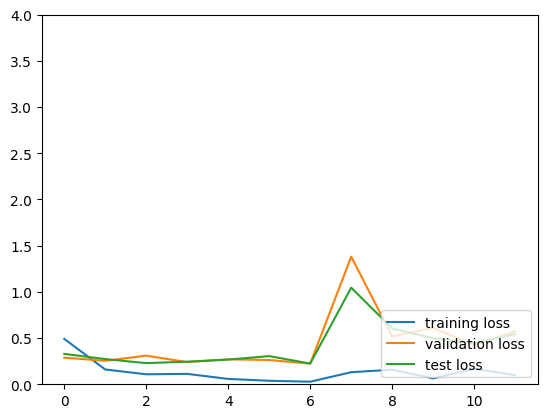

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.plot(test_loss, label='test loss')
plt.legend(loc='lower right')
plt.ylim(0,4)
plt.show()

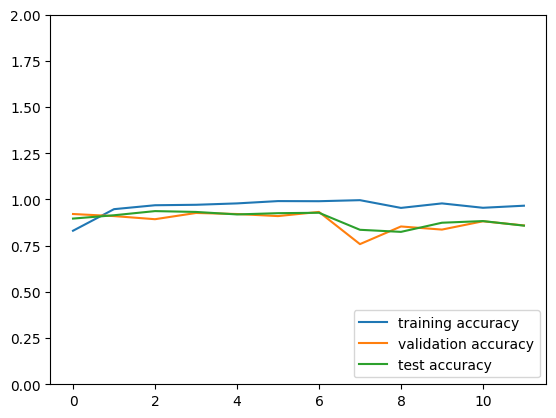

In [ ]:
plt.plot(train_acc, label='training accuracy')
plt.plot(validation_acc, label='validation accuracy')
plt.plot(test_acc, label='test accuracy')
plt.legend(loc='lower right')
plt.ylim(0,2)
plt.show()